In [139]:
# Trying new dependencies
import os
from tensorflow.keras.models import clone_model
from tensorflow.keras import regularizers


# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://static.bc-edx.com/data/dla-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


USED TO LATER CHECK FEATURE IMPORTANCE. THE PURPOSE OF THIS CLASS IS TO PROVIDE A BRIDGE BETWEEN KERAS AND SCIKIT-LEARN, ALLOWING US TO USE SCIKIT-LEARN'S TOOLS (SPECIFICALLY, PERMUATION IMPORTANCE) WITH A KERAS MODEL. 

In [140]:
# Define a custom class CustomKerasClassifier that will wrap around the 'best_model' after running the tuner search.
# This will make it compatible with permutation_importance in  scikit-learn.

class CustomKerasClassifier:
    def __init__(self, model, batch_size=64, epochs=10):
        # Store the Keras model and training parameters
        self.model = model
        self.batch_size = batch_size
        self.epochs = epochs
        self._estimator_type = "classifier"
        
    def fit(self, X, y, **kwargs):
        # Clone the model to ensure we start with untrained weights
        self.model = clone_model(self.model)
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, **kwargs)
        
    def predict(self, X):
        return self.model.predict_classes(X)
    
    def score(self, X, y):
        loss, acc = self.model.evaluate(X, y, verbose=0)
        return acc


CHECKING FOR NULL VALUES IN THE DATASET

In [141]:
application_df.isnull().sum()

EIN                       0
NAME                      0
APPLICATION_TYPE          0
AFFILIATION               0
CLASSIFICATION            0
USE_CASE                  0
ORGANIZATION              0
STATUS                    0
INCOME_AMT                0
SPECIAL_CONSIDERATIONS    0
ASK_AMT                   0
IS_SUCCESSFUL             0
dtype: int64

CHECK IF THE TARGET VARIABLE IS BALANCED & VISUALISE THE DISTRIBUTION

In [142]:
application_df["IS_SUCCESSFUL"].value_counts()

1    18261
0    16038
Name: IS_SUCCESSFUL, dtype: int64

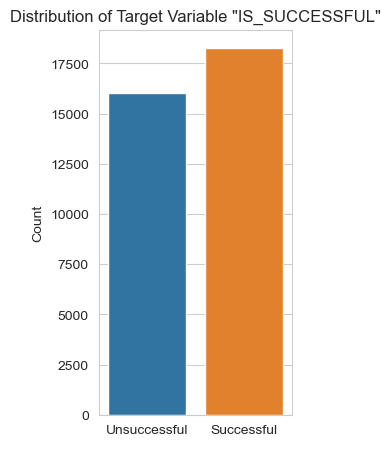

In [181]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot for the distribution of IS_SUCCESSFUL
plt.figure(figsize=(2.5,5))
sns.countplot(x='IS_SUCCESSFUL', data=application_df)
plt.title('Distribution of Target Variable "IS_SUCCESSFUL"')
plt.xlabel(' ')
plt.ylabel('Count')
plt.xticks([0, 1], ['Unsuccessful', 'Successful'])
plt.show()

FEATURE EXPLORATION:

In [100]:
# Check the balance of the 'Status' Feature to determine if we should keep or drop. 
application_df["STATUS"].value_counts()

1    34294
0        5
Name: STATUS, dtype: int64

In [101]:
# Check the balance of the 'Special_Considerations' Feature to determine if we should keep or drop. 
application_df["SPECIAL_CONSIDERATIONS"].value_counts()

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

Despite both `STATUS` and `SPECIAL_CONSIDERATIONS` potentially being non-benficial due to the large imbalance, running the model both with and without these two features yielded a better result when both were left in. So leaving them in. 

In [102]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=(["EIN", "NAME"]))
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   APPLICATION_TYPE        34299 non-null  object
 1   AFFILIATION             34299 non-null  object
 2   CLASSIFICATION          34299 non-null  object
 3   USE_CASE                34299 non-null  object
 4   ORGANIZATION            34299 non-null  object
 5   STATUS                  34299 non-null  int64 
 6   INCOME_AMT              34299 non-null  object
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object
 8   ASK_AMT                 34299 non-null  int64 
 9   IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.6+ MB


In [103]:
# Determine the number of unique values in each feature / column. Look for features that have more than 10 unique values
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [104]:
# Check unique values for the "ORGANIZATION" feature for potential binning 
application_df["ORGANIZATION"].value_counts()

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: int64

In [105]:
# Binning ORGANIZATION features
application_df["ORGANIZATION"] = application_df["ORGANIZATION"].replace(["Co-operative", "Corporation"], "Other_Organizations")

# Check binning was successful 
application_df['ORGANIZATION'].value_counts()

Trust                  23515
Association            10255
Other_Organizations      529
Name: ORGANIZATION, dtype: int64

In [106]:
# Check unique values for the "USE_CASE" feature for potential binning 
# Note incorrect spelling of 'Healthcare' 
application_df["USE_CASE"].value_counts()

Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: int64

In [107]:
# Binning USE_Case features
application_df['USE_CASE'] = application_df['USE_CASE'].replace(['CommunityServ', 'Heathcare', 'Other'], 'Other_Use_Cases')

# Check binning was successful 
application_df["USE_CASE"].value_counts()

Preservation       28095
ProductDev          5671
Other_Use_Cases      533
Name: USE_CASE, dtype: int64

In [108]:
# Check unique values for the "AFFILIATION" feature for potential binning
application_df["AFFILIATION"].value_counts()

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64

Given the significant imbalance and the lower permutation importance of certain affiliations, lets group "Family/Parent", "National", "Regional", and "Other" into a single category, "Other_Affiliations". This should simplify the feature while retaining some differentiation.

In [109]:
# Binning Affiliation features
application_df["AFFILIATION"] = application_df["AFFILIATION"].replace(["Family/Parent", "National", "Regional", "Other"], 'Other_Affiliations')

# Check binning was successful
application_df["AFFILIATION"].value_counts()

Independent           18480
CompanySponsored      15705
Other_Affiliations      114
Name: AFFILIATION, dtype: int64

In [110]:
# Check total unique values for "ASK_AMT" feature
application_df["ASK_AMT"].nunique()

8747

In [111]:
# Check unique values for the "ASK_AMT" feature for potential binning
application_df["ASK_AMT"].value_counts()

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [112]:
# View descriptive statistics to better understand the wide "ASK_AMT" range
# Set pandas display option to suppress scientific notation and display floating numbers with 0 decimal places
pd.set_option('display.float_format', '{:,.0f}'.format)
application_df["ASK_AMT"].describe()

count          34,299
mean        2,769,199
std        87,130,452
min             5,000
25%             5,000
50%             5,000
75%             7,742
max     8,597,806,340
Name: ASK_AMT, dtype: float64

In [113]:
# Iterate through specified percentiles and print the corresponding quantile value for the "ASK_AMT" feature
for percentile in [25, 50, 75, 90, 95, 99]:
    value = application_df["ASK_AMT"].quantile(q=percentile/100)
    print(f"{percentile}th percentile: {value}")

25th percentile: 5000.0
50th percentile: 5000.0
75th percentile: 7742.0
90th percentile: 196546.2000000002
95th percentile: 863507.2999999981
99th percentile: 13106354.259999901


In [163]:
# Define the bin edges based on the percentiles
bin_edges = [0, 5000, 7742, 196546, 863507, 13106354, float('inf')]

# Define the bin labels
bin_labels = [
    "Very Small Requests",
    "Small Requests",
    "Medium Requests",
    "Large Requests",
    "Very Large Requests",
    "Outliers/Extremely Large Requests"
]

# Bin the 'ASK_AMT' column
application_df['ASK_AMT_Binned'] = pd.cut(application_df['ASK_AMT'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Check the binned values
print(application_df['ASK_AMT_Binned'].value_counts())

Very Small Requests                  25398
Medium Requests                       5145
Large Requests                        1715
Very Large Requests                   1372
Outliers/Extremely Large Requests      343
Small Requests                         326
Name: ASK_AMT_Binned, dtype: int64


<Figure size 800x400 with 0 Axes>

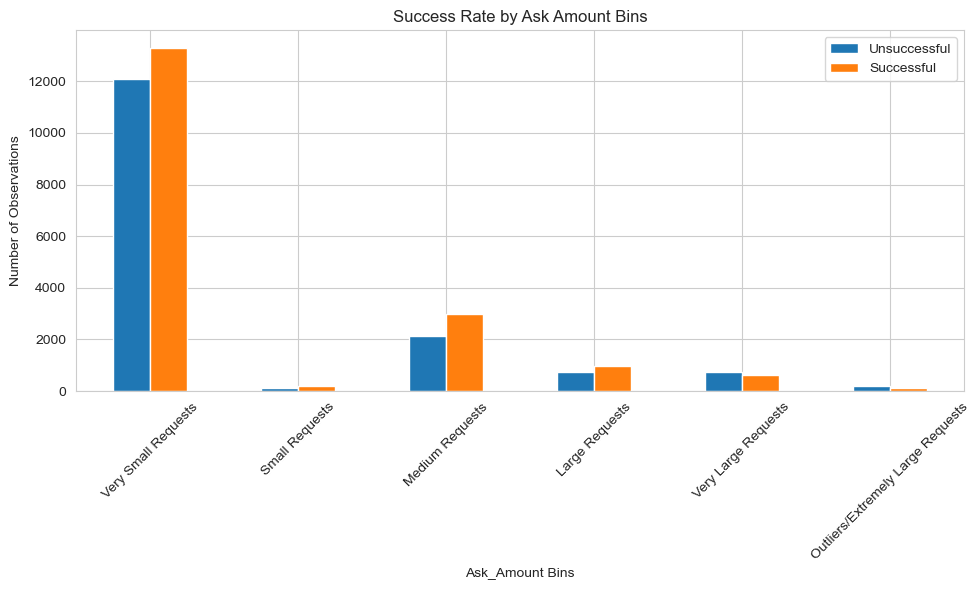

In [187]:
# Use groupby to group the data by ASK_AMT_Binned and IS_SUCCESSFUL, and then count the number of occurrences for each combination.
grouped_data = application_df.groupby(['ASK_AMT_Binned', 'IS_SUCCESSFUL']).size().unstack()

# Create a grouped bar chart
# Set figure size
plt.figure(figsize=(8, 4))

# Plot data
grouped_data.plot(kind='bar', stacked=False, figsize=(10,6))

# Set title and labels
plt.title('Success Rate by Ask Amount Bins')
plt.xlabel('Ask_Amount Bins')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.legend(labels=['Unsuccessful', 'Successful'], loc='upper right')


# Display the plot
plt.tight_layout()
plt.show()

In [115]:
# Check the lateat ammended DataFrame
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   APPLICATION_TYPE        34299 non-null  object  
 1   AFFILIATION             34299 non-null  object  
 2   CLASSIFICATION          34299 non-null  object  
 3   USE_CASE                34299 non-null  object  
 4   ORGANIZATION            34299 non-null  object  
 5   STATUS                  34299 non-null  int64   
 6   INCOME_AMT              34299 non-null  object  
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object  
 8   ASK_AMT                 34299 non-null  int64   
 9   IS_SUCCESSFUL           34299 non-null  int64   
 10  ASK_AMT_Binned          34299 non-null  category
dtypes: category(1), int64(3), object(7)
memory usage: 2.6+ MB


In [116]:
# Drop "ASK_AMT" column now that we have the newly created "ASK_AMT_BINNED" feature. 
application_df = application_df.drop(columns='ASK_AMT')
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   APPLICATION_TYPE        34299 non-null  object  
 1   AFFILIATION             34299 non-null  object  
 2   CLASSIFICATION          34299 non-null  object  
 3   USE_CASE                34299 non-null  object  
 4   ORGANIZATION            34299 non-null  object  
 5   STATUS                  34299 non-null  int64   
 6   INCOME_AMT              34299 non-null  object  
 7   SPECIAL_CONSIDERATIONS  34299 non-null  object  
 8   IS_SUCCESSFUL           34299 non-null  int64   
 9   ASK_AMT_Binned          34299 non-null  category
dtypes: category(1), int64(2), object(7)
memory usage: 2.4+ MB


In [117]:
# Adjust cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
application_types_counts = application_df["APPLICATION_TYPE"].value_counts()
application_types_to_replace = application_types_counts[application_types_counts < 500].index.tolist()

# Replace in dataframe
for app in application_types_to_replace:
    application_df["APPLICATION_TYPE"] = application_df["APPLICATION_TYPE"].replace(app,"Other")

# Check to make sure binning was successful
application_df["APPLICATION_TYPE"].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [118]:
# Adjust cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
classification_types_counts = application_df['CLASSIFICATION'].value_counts()
classifications_to_replace = classification_types_counts[classification_types_counts < 400].index.tolist()

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1484
C7000      777
Name: CLASSIFICATION, dtype: int64

In [119]:
# Convert categorical data to numeric with `pd.get_dummies`
application_df_numeric = pd.get_dummies(application_df)

# Check new DF
application_df_numeric.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_Binned_Very Small Requests,ASK_AMT_Binned_Small Requests,ASK_AMT_Binned_Medium Requests,ASK_AMT_Binned_Large Requests,ASK_AMT_Binned_Very Large Requests,ASK_AMT_Binned_Outliers/Extremely Large Requests
0,1,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [120]:
# One attempt in the Feature Engineering process that was tried:
# Drop bottom 5 features based on permutation importance. 

# application_df_numeric = application_df_numeric.drop(columns= ['APPLICATION_TYPE_T19',
#  'INCOME_AMT_100000-499999',
#  'ASK_AMT_Binned_Outliers/Extremely Large Requests',
#  'INCOME_AMT_10000-24999',
#  'USE_CASE_Heathcare'])

SPLIT OUR PRE-PROCESSED DATA FOR TRAINING & TESTING

In [121]:
# Split our preprocessed data into our features and target arrays
# Target array
y = application_df_numeric["IS_SUCCESSFUL"]

# Features array 
X = application_df_numeric.drop(columns="IS_SUCCESSFUL")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

NORMALIZE / SCALE THE PRE-PROCESSED DATA

In [122]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

DEFINE A NEURAL NETWORK MODEL FOR HYPERPARAMETER TUNING WITH `KERASTUNER`, INCORPORATING DYNAMIC ACTIVATION, REGULARIZATION, AND LAYER CONFIGURATION

In [123]:
# Define a function to create a neural network model using KerasTuner hyperparameters.
# Initialize a sequential model within the function.
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Activation and Regularizers
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Regularizers
    reg_type = hp.Choice('regularization', ['l1', 'l2', 'l1_l2'])
    l1_val = hp.Float('l1_value', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-4)
    l2_val = hp.Float('l2_value', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-4)
    if reg_type == 'l1':
        regularizer = regularizers.l1(l1_val)
    elif reg_type == 'l2':
        regularizer = regularizers.l2(l2_val)
    else: # 'l1_l2'
        regularizer = regularizers.l1_l2(l1=l1_val, l2=l2_val)

    # First Layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
            min_value=1,
            max_value=80,
            step=2), activation=activation, kernel_regularizer=regularizer, input_dim=X_train_scaled.shape[1]))

    # Hidden Layers
    for i in range(hp.Int('num_layers', 1, 12)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                min_value=1,
                max_value=30,
                step=2), activation=activation, kernel_regularizer=regularizer))

    # Output Layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model


In [124]:
# Remove the KerasTuner cache directory to start tuning from scratch and prevent using previous tuning results.
import shutil
shutil.rmtree('./untitled_project')

In [125]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=10,
    hyperband_iterations=2)

In [126]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=30,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 05s]
val_accuracy: 0.7241982221603394

Best val_accuracy So Far: 0.7264139652252197
Total elapsed time: 00h 03m 00s


In [135]:
# Retrieve the best trained model from the tuner's results
best_model = tuner.get_best_models(num_models=1)[0]

In [136]:
# Evaluate the model using the training data
train_loss, train_accuracy = best_model.evaluate(X_train_scaled, y_train, verbose=0)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

# Evaluate the model using the test data
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Training Loss: 0.6039421558380127, Training Accuracy: 0.7316902279853821
Test Loss: 0.610766589641571, Test Accuracy: 0.7264139652252197


EXPLORE PERMUTATION IMPORTANCE TO BETTER UNDERSTAND THE FEATURES

In [129]:
# Create an instance of the CustomKerasClassifier using the best_model
# This can now be used with sci-kit-learn's Permutation Importance tool
wrapped_model = CustomKerasClassifier(best_model)

In [134]:
# Calculate permutation importance and store the sorted list based on the features importance scores
result = permutation_importance(wrapped_model, X_train_scaled, y_train, n_repeats=30, random_state=1)

# Provide the average Importance score over 30 repeats 
sorted_idx = result.importances_mean.argsort()
print(sorted_idx)

[37 31 36 35 38 13 26  9 40  0 16 14 21  8 12 39 29  3 22 32 20 34 33 42
  1 17 15 24 30  4 28 19  5 27 25 41 18 23  7  2  6 11 10]


In [137]:
print(sorted_idx)

[37 31 36 35 38 13 26  9 40  0 16 14 21  8 12 39 29  3 22 32 20 34 33 42
  1 17 15 24 30  4 28 19  5 27 25 41 18 23  7  2  6 11 10]


In [149]:
# Get the sorted Importance values based on the indices
sorted_importance_values = result.importances_mean[sorted_idx]

# Arrange in descending order / most important feature first
sorted_importance_values = sorted_importance_values[::-1]

VISUALISE THE FEATURE IMPORTANCE SCORES:

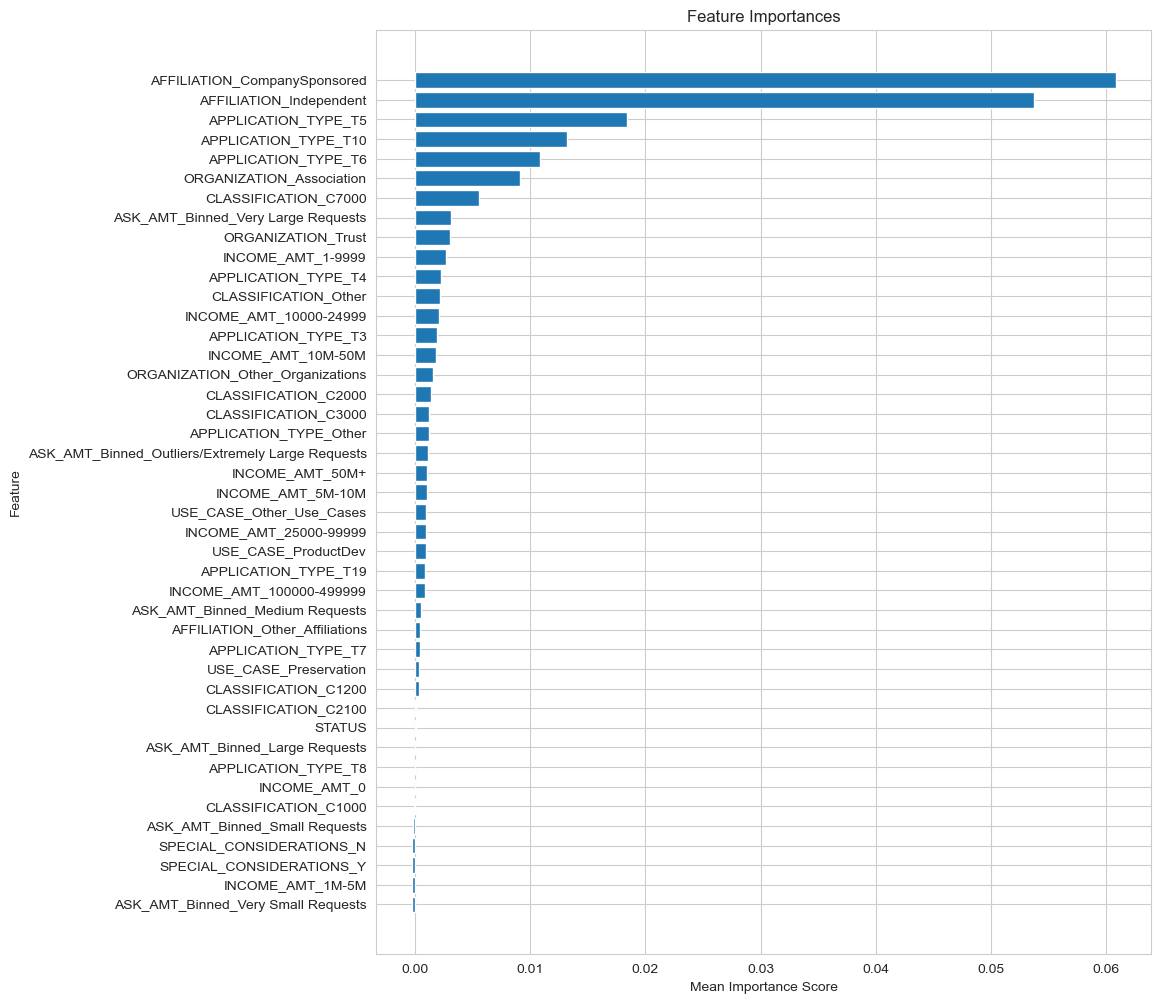

In [183]:
# Set the figure size
plt.figure(figsize=(10, 12))

# Plot the feature importances
plt.barh(sorted_feature_names, sorted_importance_values, align='center')

# Set the title and labels
plt.title('Feature Importances')
plt.xlabel('Mean Importance Score')
plt.ylabel('Feature')

# Display the plot
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()

In [ ]:
# # Plotting the permutation importance
# plt.figure(figsize=(10, len(sorted_idx)))
# plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
# plt.title("Permutation Importances (train set)")
# plt.show()

LIST FEATURES IN ORDER OF PERMUTATION IMPORTANCES:

In [154]:
# Get feature names
feature_names = X_train.columns.tolist()

# Map sorted indices to feature names
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Since the order is currently from least to most important, reverse it
sorted_feature_names = sorted_feature_names[::-1]

# show most important Features in descending order
sorted_feature_names

['AFFILIATION_CompanySponsored',
 'AFFILIATION_Independent',
 'APPLICATION_TYPE_T5',
 'APPLICATION_TYPE_T10',
 'APPLICATION_TYPE_T6',
 'ORGANIZATION_Association',
 'CLASSIFICATION_C7000',
 'ASK_AMT_Binned_Very Large Requests',
 'ORGANIZATION_Trust',
 'INCOME_AMT_1-9999',
 'APPLICATION_TYPE_T4',
 'CLASSIFICATION_Other',
 'INCOME_AMT_10000-24999',
 'APPLICATION_TYPE_T3',
 'INCOME_AMT_10M-50M',
 'ORGANIZATION_Other_Organizations',
 'CLASSIFICATION_C2000',
 'CLASSIFICATION_C3000',
 'APPLICATION_TYPE_Other',
 'ASK_AMT_Binned_Outliers/Extremely Large Requests',
 'INCOME_AMT_50M+',
 'INCOME_AMT_5M-10M',
 'USE_CASE_Other_Use_Cases',
 'INCOME_AMT_25000-99999',
 'USE_CASE_ProductDev',
 'APPLICATION_TYPE_T19',
 'INCOME_AMT_100000-499999',
 'ASK_AMT_Binned_Medium Requests',
 'AFFILIATION_Other_Affiliations',
 'APPLICATION_TYPE_T7',
 'USE_CASE_Preservation',
 'CLASSIFICATION_C1200',
 'CLASSIFICATION_C2100',
 'STATUS',
 'ASK_AMT_Binned_Large Requests',
 'APPLICATION_TYPE_T8',
 'INCOME_AMT_0',
 'CLAS